In [1]:
import sys
import cuentitas
from auxiliares import generadorFran  #generador, generador1E, generadorEmisividad, 

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd
import glob
import theano.tensor as TT
import random

import time

import pymc3 as pm

sns.set() #seaborn como default

# m = 51 #valores que siempre uso
# X,Y,Wt = ig(m-1)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# A partir de generadorFran, que devuelve "len(anguloR)" valores de s0 y una emi en nadir, para los parametros
# elejidos, los convierto a forma tensorial y los devuelte en subtensores

def toFitFran(ep1,ep2,d,s1,l1,s2,l2,anguloR,landa): #Me devuelve un tensor de nn+mm, con nn valores de angulos s0 y mm emis
    
    s0s = generadorFran(ep1,ep2,d,s1,l1,s2,l2,incAng,landa)
    
    pp = len(s0s[1])   
    a = TT.zeros(pp)

    for i in range(pp):
        a = TT.set_subtensor(a[i], s0s[1][i])
        
    return a


In [3]:
# Resuelve mediante inferencia bayesiana utilizando algoritmo sequential monte carlo sampler (SMC) los parametros ep1,ep2,etc
# que mejor resuelven los valores de entrada. 
# La devolucion es una matriz con la distribución posterior. Este este contiene para cada columna los juegos de parametros que 
# explican los valores de entrada a partir de un cierto error sigma definido

# sector: Valores de entrada de s0 y emi de la zona estudiada, definida por "auxiliares.py/medicion()" o por una funcion que 
#         devuelta en primer lugar un array de n angulos en donde se mide y en segundo lugar un array con las mediciones. 
# angWR: es el angulo sin ruido para simulaciones con emisividad, es indistinto el valor 
#         que tome si uso la f() sin emisividad
# landa: frecuencia de operacion
# samples: cantidad de muestras del espacio de parametros
# sigmas: array error de [deltaSo, deltaEmi]


def modelo(sector, angWR, landa, samples, sigmas): 
    
    phi = np.pi
    
    print('Valores de entrada: ', sector[1])
    print('Cantidad de datos: ', sector[1].shape)

    #Rango en donde estudiamos los parametros
    ranges = {}
    ranges['ep1'] = 1.4, 8
    ranges['ep2'] = 1.4, 8
    ranges['d'] = 0.001, 0.5
    ranges['s1'] = 0.0004, 0.004
#     ranges['l1'] = 0.005, 0.03
    ranges['s2'] = 0.0004, 0.004
#     ranges['l2'] = 0.005, 0.03

    #distribucion a priori de cada uno
    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
#         l1 = pm.Uniform('l1', ranges['l1'][0], ranges['l1'][1])
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])
#         l2 = pm.Uniform('l2', ranges['l2'][0], ranges['l2'][1])

    #Funcion de costo a minimizar
    def f(ep1 = ep1,
          ep2 = ep2,
          d = d,
          s1 = s1,
#           l1 = l1,
          s2 = s2
#           l2 = l2
         ):
#         return toFitEmis(ep1,ep2,d,s1,0.015,s2,0.01,angWR,sector[0])
        return toFitFran(ep1,ep2,d,s1,0.015,s2,0.01,sector[0],landa)
    
    with model:
        function_pm = pm.Deterministic('s0f', f()) #funcion de costo
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1]) #observaciones
        trace = pm.sample_smc(samples, cores=4, parallel=True) #metodo de exploracion de parametros
    
    return trace

In [4]:
# ----- Para agregar ruido aleatorio a las mediciones ----- 

# 'se' son los valores reales del modelo, 1 s0 para cada angulo y si es generador1E da 1 emisividad en nadir
# o si es generadorEmisividad da la misma cantidad de emisividades evaluado en cada thi
# 'seR' son los valores de s0 perturbados segun noiseSTD, estos estan en la cantidad de antes pero 
# multiplicados por 'n', en cuanto a la emisividad aparecen las mismas cantidades que antes

# C = 3 #cantidad de angulos iniciales
# [ang,se] = generador1E(C) #genera una emisividad global


# #[ang,se] = generadorEmisividad(C) #genera una emisividad para cada angulo
# val = se[:len(ang)]
# emi = se[len(ang):]

# val = np.reshape(val,(len(val),1))
# n = 1 #cantidad de "perturbaciones" de cada angulo

# noiseSTD = 0.1
# valRui = np.kron(val,np.ones((n,1))) + noiseSTD*np.random.randn(n*len(val),1)

# angR = np.reshape(ang,(len(ang),1))
# angR = np.kron(angR,np.ones((n,1)))

# angR = np.reshape(angR, (len(angR)))
# valR = np.reshape(valRui, (len(valRui)))

# emi = np.reshape(emi,(len(emi),1))
# emiRui = emi + 0.01*np.random.randn(len(emi),1)
# emiR = np.reshape(emiRui,(len(emi)))

# seR = np.concatenate((valR,emiR))




In [4]:
# Angulos estudiados en datos sinteticos. Este array debe contar con al menos 1 valor.
# landa: longitudes de onda de operacion. Este array debe contar con al menos 1 valor.

# incAng = [20,60]
# landa = [0.025]

incAng = [20]
landa = [0.025,0.05]

# incAng = [20,60]

array([array([20]),
       array([ -4.62545005, -14.7996328 ,   0.95510102,   0.99527202])],
      dtype=object)

In [14]:
# Prueba de la forma tensorial para ajustar
qw = toFitFran(1.93,
            5.0,
            0.3,
            0.001,
            0.015,
            0.002,
            0.01,
            incAng,
            landa)
qw.eval()

array([ -4.62545005, -14.7996328 ,   0.95510102,   0.99527202])

In [ ]:
# qw[1].shape

In [19]:
# Datos de entrada para la inferencia

# set1
surfaceModelParam = [1.93,
                    5.0,
                    0.3,
                    0.001,
                    0.002]

entradaModelo = generadorFran(surfaceModelParam[0], 
                surfaceModelParam[1],
                surfaceModelParam[2],
                surfaceModelParam[3],
                0.015,
                surfaceModelParam[4],                
                0.01,
                incAng,
                landa)
entradaModelo

array([array([20]),
       array([ -4.62545005, -14.7996328 ,   0.95510102,   0.99527202])],
      dtype=object)

In [12]:
# m = 51
# X,Y,Wt = ig(m-1)

t0 = time.time()

# Cantidad de realizaciones para la cadena 
muestras = 20000
Nombre = 'Delta'

sig = np.asarray(len(incAng)*len(landa)*[0.1] + len(landa)*[0.01])
traza = modelo(entradaModelo, np.asarray([0.0001]), landa, muestras, sig)




#------------ error para generador1E() con ruido aleatorio ------------#
#sig = np.asarray(len(angR)*[noiseSTD**2] + [0.05])

#------------ error para generadorEmisividad()) con ruido aleatorio ------------#
# sig = np.asarray(len(angR)*[noiseSTD**2] + len(ang)*[0.001])
# traza = modelo([angR,seR],ang,muestras,sig)

[ -4.62545005 -14.7996328    0.95510102   0.99527202]
(4,)


Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op real does not provide a C implementation. As well as be

In [20]:
plotear = np.stack((traza['ep1'],traza['ep2'],traza['d'], traza['s1'], traza['s2'])).T
dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','s2'])

In [53]:
#Ploteo


# g = sns.PairGrid(dfplotear)
# g.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
# # g.map_upper(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True, color='.5')
# g.savefig(Nombre+'.png')

In [21]:
# modelIn = [1.93,5,0.05,0.0017,0.015,0.003,0.01]
modelInReduced = [surfaceModelParam[0], 
                  surfaceModelParam[1],
                  surfaceModelParam[2],
                  surfaceModelParam[3],
                  surfaceModelParam[4]]


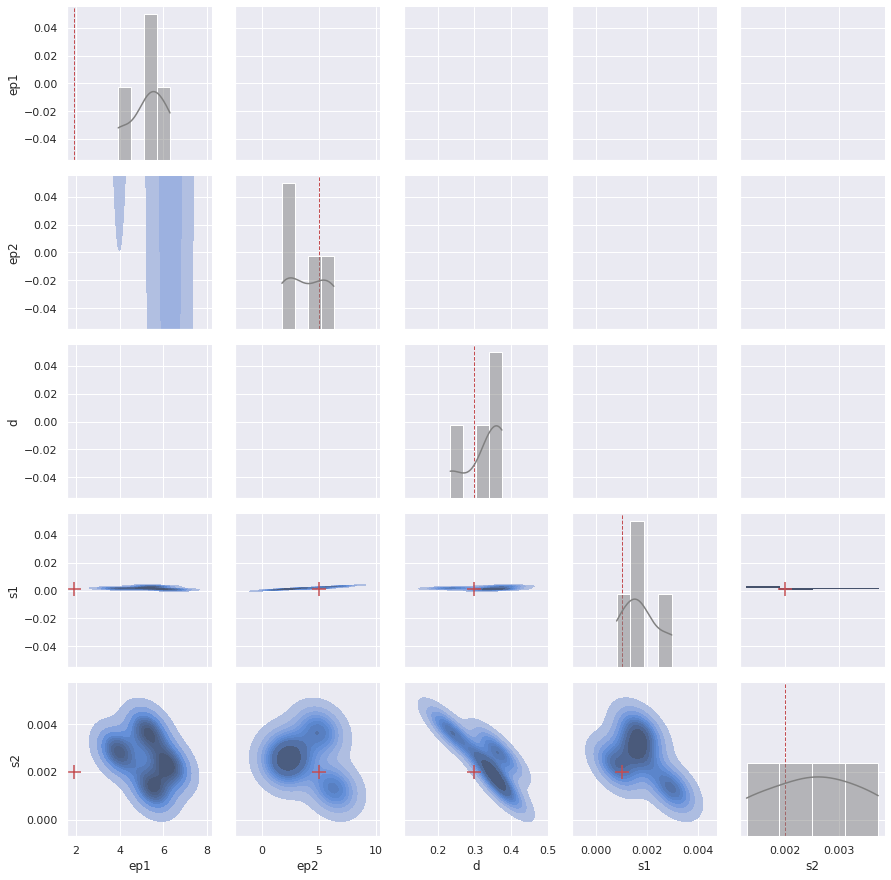

In [24]:
f = sns.PairGrid(dfplotear)
# f.fig.suptitle(Nombre, y=1.01, fontsize = 'large')
f.map_upper(sns.histplot)

f.map_lower(sns.kdeplot, fill=True)
f.map_diag(sns.histplot, kde=True, color='.5')

for i in range(len(modelInReduced)):
    for j in range(len(modelInReduced)):
        if i == j:
            #ploteo el valor verdadero en las marginales
            f.axes[j,i].axvline(modelInReduced[i], color='r', linestyle='dashed', linewidth=1)
#             pass
        else:
            #ploteo sobre las cross-correlaciones
            f.axes[j,i].scatter(modelInReduced[i], modelInReduced[j], marker="+", c='r', s=200) #color='k', linestyle='dashed', linewidth=1)

In [25]:
t1 = time.time()
print("Tiempo de ejecución:", t1-t0, 'seg','(', (t1-t0)/3600,  'hs )')

nombre = "set1-2Capas-noNoise-2s0+2emi-2lambda"
# f.savefig('Resultados/'+nombre+'.png', dpi=300)

Tiempo de ejecución: 912.5915765762329 seg ( 0.2534976601600647 hs )


In [26]:
e1 = traza['ep1']
e2 = traza['ep2']
d = traza['d']
s1 = traza['s1']
s2 = traza['s2']

guardar = [e1,e2,d,s1,s2]

# f_ = np.savetxt('Resultados/'+nombre+'Trazas.txt', guardar, delimiter=';')
# f2_ = np.savetxt('Resultados/'+nombre+'Trazas-input.txt', np.asarray([np.asarray(incAng),np.asarray(modelInReduced)],dtype=object), fmt='%s', delimiter=';')